# Homework #2 (Due 09/25/2019, 11:59pm)
## Sampling and Monte Carlo Integration

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name:** Rylan Schaeffer

**Students collaborators:**

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Description

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of the random variable $X$:

$$
h(x) = 7 * \mathrm{exp}\left\{\frac{(x-4)^2}{-2}\right\} + 3 * \mathrm{exp}\left\{\frac{(x-8)^2}{-2 * 0.7^2}\right\}
$$

Our goal is to compute the expected value of $h(X)$:
$$
I = \mathbb{E}_{X\sim f_X}\left[h(X)\right] = \int_{\Omega} h(x) f_X(x)dx,
$$
where $\Omega$ is the domain of $f_X$.

## Part I. Implement Some Monte Carlo Estimates

Approximate $\mathbb{E}_{X\sim f_X}[h(X)]$ using the Monte Carlo integration methods and your choice of a reasonable fixed $S$ (for rejection sampling, this means run the algorithm $S$ times):


1. ***Inverse CDF Sampling*** and naive Monte Carlo estimation.<br><br>

2. ***Rejection Sampling*** and naive Monte Carlo estimation, using each of the following

  - a uniform proposal distribution
  - a normal proposal distribution 

  and your choice of reasonable parameters for the proposal distributions.<br><br>
  
3. ***Importance Sampling*** using each of the following

  - a uniform importance distribution 
  - a normal importance distribution

  and your choice of reasonable parameters for the importance distributions.<br><br>
  
2. ***Stratified Sampling*** using 4 strata, whose end points are given by
$$
[1, 3, 5, 7, 9].
$$
Use inverse cdf sampling on each stratum.

In [2]:
num_runs = 500
num_samples = 1000

In [3]:
# define density
def f(x):
    result = 0
    if 1 <= x and x <= 3:
        result = (x-1)/12
    elif 3 < x and x <= 5:
        result =  -1*(x-5)/12
    elif 5 < x and x <= 7:
        result = (x - 5)/6
    elif 7 < x and x <= 9:
        result = -1*(x-9)/6
    return result
vf = np.vectorize(f, otypes=[np.float])

# define function
def h(x):
    term1 = 7 * np.exp((x-4)**2 / (-2))
    term2 = 3 * np.exp((x-8)**2 / (-2*0.49))
    return term1 + term2
    
vh = np.vectorize(h, otypes=[np.float])

In [4]:
# inverse CDF sampling
def f_inv(u):
    # u is between 0 and 1
    x = 0.
    if u <= 1/6:
        x = np.roots([1/24, -1/12, 1/24 - u])[0]
    elif 1/6 < u and u <= 1/3:
        x = np.roots([1/24, -5/12, u + 17/24])[1]
    elif 1/3 < u and u <= 2/3:
        x = np.roots([1/12, -5/6, 29/12 - u])[0]
    elif 2/3 < u:
        x = np.roots([1/12, -3/2, u + 23/4])[1]
    return x

vf_inv = np.vectorize(f_inv, otypes=[np.float])

def inverse_cdf_sampling(size=num_samples):
    cdf_samples = np.random.uniform(size=size)
    x_samples = vf_inv(cdf_samples)
    return x_samples

In [5]:
# rejection sampling using Unif(0, 10)

# Calculate M
x_ticks = np.arange(0, 10, 0.01)
g = 0.1
f_x = vf(x_ticks)
print('M should be larger than: ', np.max(f_x / g))

def uniform_rejection_sampling(size=num_samples):
    x_samples = []
    M = 3.5
    g = .1
    for _ in range(size):
        proposal_sample = np.random.uniform(0, 10, size=1)
        height = np.random.uniform(0, 1, size=1)
        p_proposal_sample = f(proposal_sample)
        if p_proposal_sample > M*g*height:
            x_samples.append(proposal_sample[0])
    return x_samples

M should be larger than:  3.333333333333333


In [6]:
# rejection sampling using N(7, 3)
from scipy.stats import norm

loc, scale = 7, 3

# Calculate M
x_ticks = np.arange(0, 10, 0.01)
f_x = vf(x_ticks)
g = norm.pdf(x_ticks, loc=loc, scale=scale)
print('M should be larger than: ', np.max(f_x / g))

def normal_rejection_sampling(size=num_samples):
    x_samples = []
    M = 3.333
    for _ in range(size):
        proposal_sample = np.random.normal(loc=loc, scale=scale, size=1)
        height = np.random.uniform(0, 1, size=1)
        p_proposal_sample = f(proposal_sample)
        g = norm.pdf(proposal_sample, loc=loc, scale=scale)
        if p_proposal_sample > M*g*height:
            x_samples.append(proposal_sample[0])
    return x_samples

M should be larger than:  3.048593209824235


In [7]:
# importance sampling
# uniform importance distribution
from scipy.stats import uniform

def uniform_importance_sampling(size=num_samples):
    loc, scale = 0, 10
    easy_samples = uniform.rvs(loc=loc, scale=scale, size=size)
    samples_prob_for_easy_distr = uniform.pdf(easy_samples, loc=loc, scale=scale)
    samples_prob_for_hard_distr = vf(easy_samples)
    return easy_samples, samples_prob_for_easy_distr, samples_prob_for_hard_distr

In [8]:
# importance sampling
# normal importance distribution
from scipy.stats import norm

def normal_importance_sampling(size=num_samples):
    loc, scale = 6, 3
    easy_samples = norm.rvs(loc=loc, scale=scale, size=size)
    samples_prob_for_easy_distr = norm.pdf(easy_samples, loc=loc, scale=scale)
    samples_prob_for_hard_distr = vf(easy_samples)
    return easy_samples, samples_prob_for_easy_distr, samples_prob_for_hard_distr

In [9]:
def f_inv_stratified(u, i):
    # u is between 0 and 1
    x = 0
    if i == 0:
        x = np.roots([-1/4, 1/2, (u - 1/4)])[0]
    elif i == 1:
        x = np.roots([1/4, -5/2, (u + 21/4)])[1]
    elif i == 2:
        x = np.roots([-1/4, 5/2, (u - 25/4)])[0]
    elif i == 3:
        x = np.roots([1/4,  -9/2,  (u + 77/4)])[1]
    return x


In [10]:
# stratified sampling
normalization_constants = np.array([1/6, 1/6, 1/3, 1/3])

def stratified_sampling(size=num_samples):
    endpoints = np.arange(1, 10, 2)
    num_endpoints = len(endpoints) - 1
    num_samples_per_strata = (num_samples * normalization_constants).astype(np.int)
    x_samples = []
    for i, strata in enumerate(zip(endpoints[:-1], endpoints[1:])):
        strata_start, strata_end = strata
        num_samples_in_strata = num_samples_per_strata[i]
        cdf_samples = np.random.uniform(size=num_samples_in_strata)
        x_sample_in_strata = vf_inv_stratified(cdf_samples, i)
        x_samples.append(x_sample_in_strata)
    return x_samples

vf_inv_stratified = np.vectorize(f_inv_stratified, otypes=[np.float])

In [11]:
monte_carlo_estimates = []

for run_num in range(num_runs):
    
    # inverse cdf sampling
    inverse_cdf_samples = inverse_cdf_sampling()
    inverse_cdf_h = vh(inverse_cdf_samples)
    inverse_h_mean = np.mean(inverse_cdf_h)
    
    # stratified sampling
    stratified_samples = stratified_sampling()
    stratified_h_mean = np.sum(normalization_constants * [np.mean(vh(strata_samples)) for strata_samples in stratified_samples])
    
    # normal importance sampling
    normal_imp_samp_vars = normal_importance_sampling()
    normal_imp_samp_h = vh(normal_imp_samp_vars[0]) * normal_imp_samp_vars[2] / normal_imp_samp_vars[1]
    normal_imp_h_mean = np.mean(normal_imp_samp_h)
    
    # uniform importance sampling
    uniform_imp_samp_vars = uniform_importance_sampling()
    uniform_imp_samp_h = vh(uniform_imp_samp_vars[0]) * uniform_imp_samp_vars[2] / uniform_imp_samp_vars[1]
    uniform_imp_h_mean = np.mean(uniform_imp_samp_h)
    
    # normal rejection sampling
    normal_rejection_samples = normal_rejection_sampling()
    normal_rejection_h = vh(normal_rejection_samples)
    normal_rej_h_mean = np.mean(normal_rejection_h)
    
    # uniform rejection sampling
    uniform_rejection_samples = uniform_rejection_sampling()
    uniform_rejection_h = vh(uniform_rejection_samples)
    uniform_rej_h_mean = np.mean(uniform_rejection_h)
    
    monte_carlo_estimates.append((inverse_h_mean, stratified_h_mean, normal_imp_h_mean,
                                 uniform_imp_h_mean, normal_rej_h_mean, uniform_rej_h_mean))

monte_carlo_estimates = pd.DataFrame(monte_carlo_estimates)
monte_carlo_estimates.columns = [
    'inverse_cdf',
    'stratified',
    'normal_imp',
    'uniform_imp',
    'normal_rej',
    'uniform_rej']


In [12]:
data = {
    'estimator_mean': monte_carlo_estimates.mean(axis=0).values,
    'estimator_var': monte_carlo_estimates.var(axis=0).values,
}
monte_carlo_estimator_moments = pd.DataFrame(data, index=monte_carlo_estimates.columns)
print(monte_carlo_estimator_moments)

             estimator_mean  estimator_var
inverse_cdf        2.440290       0.003283
stratified         2.438433       0.000617
normal_imp         2.447607       0.005736
uniform_imp        2.439045       0.006339
normal_rej         2.436382       0.011775
uniform_rej        2.432387       0.011448


### Part II Question 1

Visualize the pdf $f_X$ as well as samples obtained from Inverse CDF Sampling and Rejection Sampling (for both proposal distributions). It's probably better to make separate plots for each set of samples.

What does the comparison say about the quality of your samples? In particular, which sampler (and which proposal distribution) produces "better" samples? Is this surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?

Hint: you might find it helpful to visualize the proposal distributions along with $f_X$
in your analysis of rejection sampling.

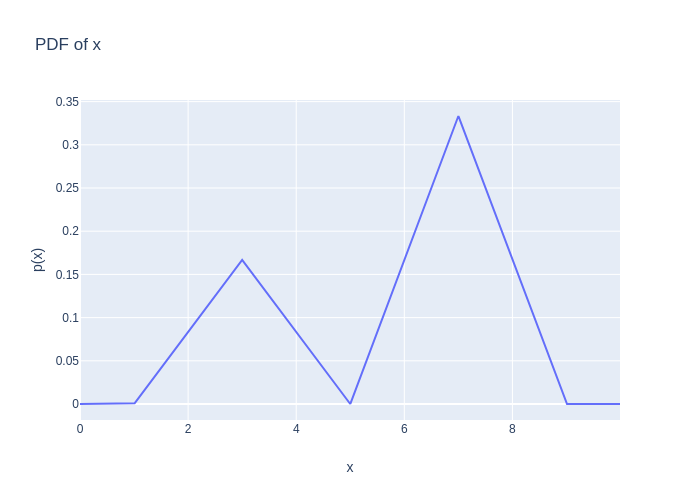

In [13]:
import plotly

x = np.arange(0, 10, .01)
f_x = vf(x)

import plotly
import plotly.graph_objs as go
import plotly.io as pio
from IPython.display import Image

data = [go.Scatter(x=x, y=f_x, mode='lines', name='f(x)')]
layout = dict(
    title='PDF of x',
    xaxis=dict(title='x'),
    yaxis=dict(title='p(x)')
)

fig = go.Figure(data=data, layout=layout)
Image(pio.to_image(fig, format='png'))


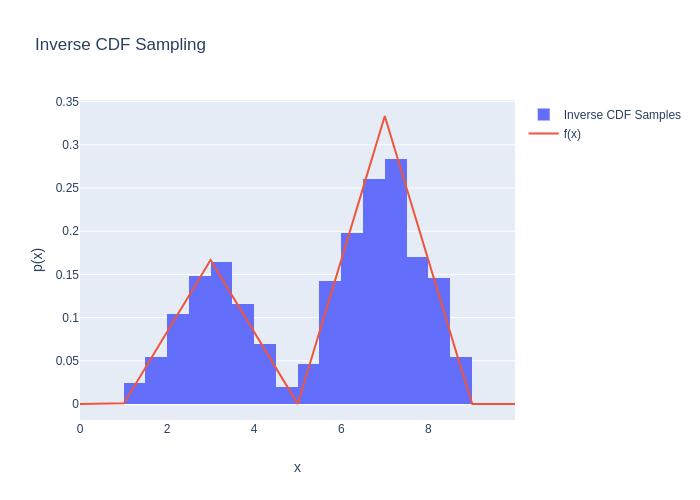

In [14]:
# plot inverse CDF sampling

inverse_cdf_samples = inverse_cdf_sampling() 

data = [
    go.Histogram(x=inverse_cdf_samples, histnorm='probability density', name='Inverse CDF Samples'),
    go.Scatter(x=x, y=f_x, mode='lines', name='f(x)')]

layout = dict(
    title='Inverse CDF Sampling',
    xaxis=dict(title='x'),
    yaxis=dict(title='p(x)'))

fig = go.Figure(data=data, layout=layout)
Image(pio.to_image(fig, format='png'))

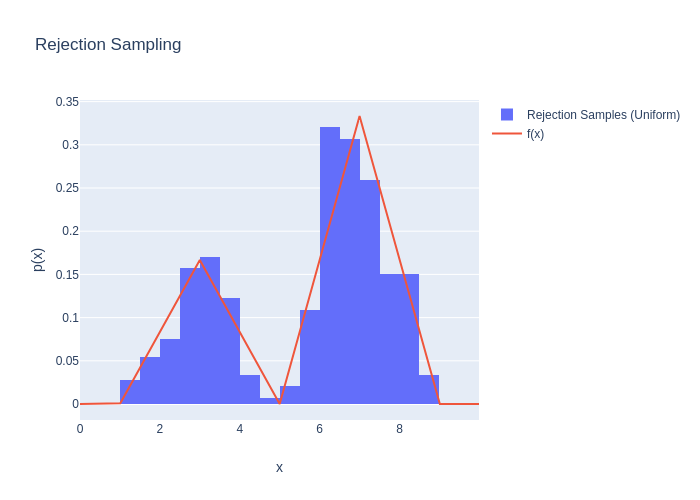

In [15]:
# plot uniform rejection samples

uniform_rejection_samples = uniform_rejection_sampling()

data = [
    go.Histogram(x=uniform_rejection_samples, histnorm='probability density', name='Rejection Samples (Uniform)'),
    go.Scatter(x=x, y=f_x, mode='lines', name='f(x)')]

layout = dict(
    title='Rejection Sampling',
    xaxis=dict(title='x'),
    yaxis=dict(title='p(x)'))

fig = go.Figure(data=data, layout=layout)
Image(pio.to_image(fig, format='png'))

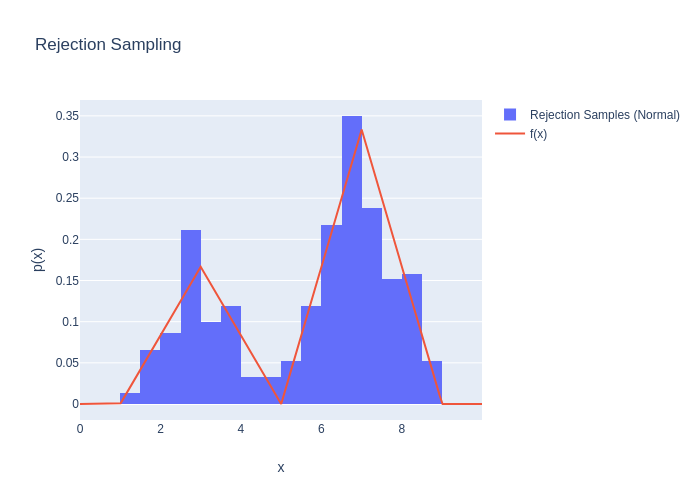

In [16]:
# plot normal rejection samples
normal_rejection_samples = normal_rejection_sampling()

data = [
    go.Histogram(x=normal_rejection_samples, histnorm='probability density', name='Rejection Samples (Normal)'),
    go.Scatter(x=x, y=f_x, mode='lines', name='f(x)')]

layout = dict(
    title='Rejection Sampling',
    xaxis=dict(title='x'),
    yaxis=dict(title='p(x)'))

fig = go.Figure(data=data, layout=layout)
Image(pio.to_image(fig, format='png'))

The inverse CDF sampling algorithm has significantly lower variance than the two rejection sampling algorithms. This makes sense given that the rejection sampling algorithms exclude so many samples; on one particular run, Normal excluded 1020 of 2500 samples and Uniform excluded 1065 of 2500 samples.

There isn't much of a difference between the two proposal distributions. If anything, the Uniform proposal distribution has slightly higher variance than the Normal proposal distribution, which is a bit surprising since the Normal distribution rejected fewer samples than the Uniform distribution and thus has more samples. I think this can be explained by the property that the Gaussian is more likely to generate and subsequently keep samples near high density regions of $f(x)$.

### Part II Question 2

Visualize the distribution of the importance weights (one for each importance distribution). 
  
   Is the weight distribution surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?

   What do these importance weights tell you about the quality of your importance sampling estimate? 
   
     **Hint:** you might find it helpful to visualize the importnce distributions along with $f_X$ and $h$ in your analysis of importance sampling.

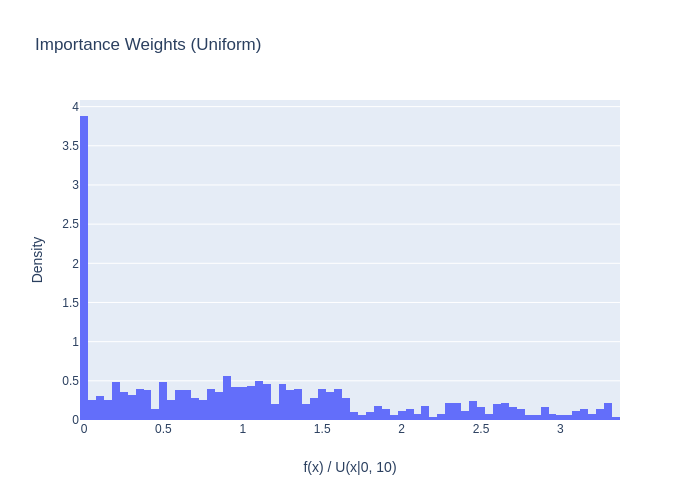

In [17]:
# plot distribution of importance weights
# uniform
uniform_imp_samp_vars = uniform_importance_sampling()
_, p_uniform_x, p_f_x = uniform_imp_samp_vars

uniform_imp_ratio = p_f_x / p_uniform_x

data = [
    go.Histogram(x=uniform_imp_ratio, histnorm='probability density', nbinsx=100, name='Importance Weights (Normal)'),
]

layout = dict(
    title='Importance Weights (Uniform)',
    xaxis=dict(title='f(x) / U(x|0, 10)'),
    yaxis=dict(title='Density'))

fig = go.Figure(data=data, layout=layout)
Image(pio.to_image(fig, format='png'))

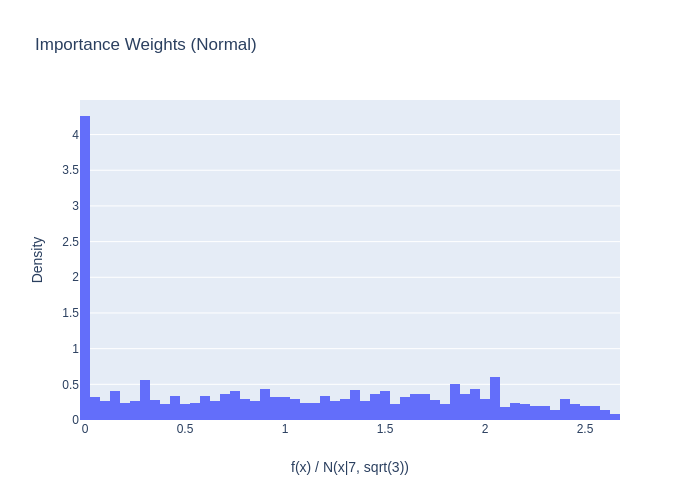

In [18]:
# plot distribution of importance weights
# normal
normal_imp_samp_vars = normal_importance_sampling()
_, p_normal_x, p_f_x = normal_imp_samp_vars

normal_imp_ratio = p_f_x / p_normal_x

data = [
    go.Histogram(x=normal_imp_ratio, histnorm='probability density', nbinsx=100, name='Importance Weights (Normal)'),
]

layout = dict(
    title='Importance Weights (Normal)',
    xaxis=dict(title='f(x) / N(x|7, sqrt(3))'),
    yaxis=dict(title='Density'))

fig = go.Figure(data=data, layout=layout)
Image(pio.to_image(fig, format='png'))

Both plots display a salient features: a peak at 0. This corresponds to points where the alternative distribution (either the Uniform or the Normal) have support that the target distribution ($f(x)$) does not. We can clearly see this in the case of the Uniform; the uniform extends from 0 to 10 and 0 to 1 and 9 to 10 constitute 20% of the support where $f(x)$ has no density. The uniform importance sampling also has a peak around 1.6 or 1.7, which corresponds to locations where $f(x)$ is greater than the uniform distribution, which makes sense given that $f(x)$ has two large spikes at 3 and 7 that exceed the uniform distributions.

These weights tell me that a significant number of samples were wasted (approximately 20% of the uniform samples). The lesson here is that we want the support of the target distribution to match the support of the alternative distribution as closely as possible.

### Part II Question 3

Visualize the distribution of all the samples across strata. Is the distribution what you expect -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?

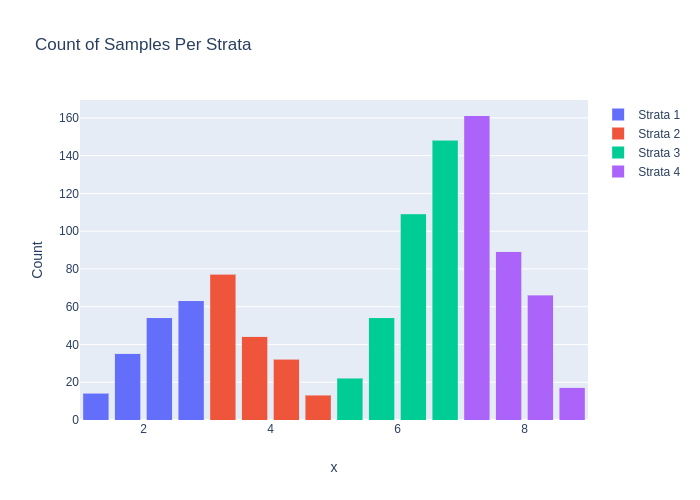

In [19]:
stratified_samples = stratified_sampling()

data = [
    go.Histogram(x=strata_sample, name='Strata {}'.format(i+1))
    for i, strata_sample in enumerate(stratified_samples)]

layout = dict(
    title='Count of Samples Per Strata',
    xaxis=dict(title='x'),
    yaxis=dict(title='Count'))

fig = go.Figure(data=data, layout=layout)
Image(pio.to_image(fig, format='png'))

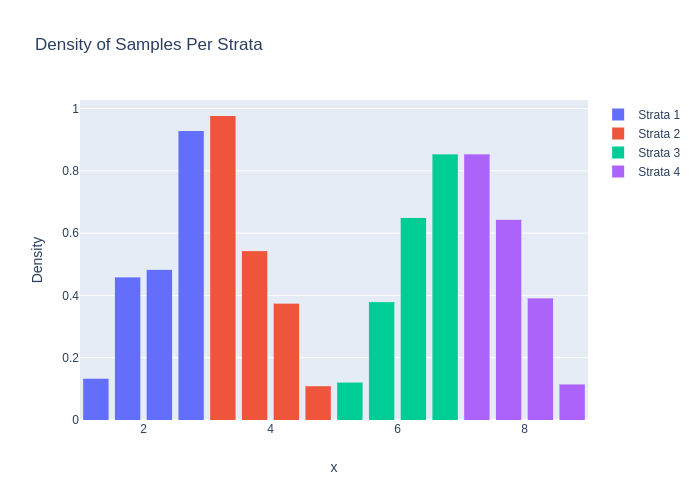

In [20]:
stratified_samples = stratified_sampling()

data = [
    go.Histogram(x=strata_sample, histnorm='probability density', name='Strata {}'.format(i+1))
    for i, strata_sample in enumerate(stratified_samples)]

layout = dict(
    title='Density of Samples Per Strata',
    xaxis=dict(title='x'),
    yaxis=dict(title='Density'))

fig = go.Figure(data=data, layout=layout)
Image(pio.to_image(fig, format='png'))

The counts across each strata matches the overall distribution $f(x)$, and the densities within each strata perfectly sums to 1, which is what we expect.

### Part II Question 4
(Extra Credit) Compute the effective sample size (ESS) of the importance sampling estimates (for both distributions). You'll need to look up the definition of ESS (there are three commonly used definitions, pick any one). How does the effective sample size relate to the trends in the importance weight distributions?

In [21]:
# using the definition from http://www.nowozin.net/sebastian/blog/effective-sample-size-in-importance-sampling.html
# ESS = (sum weights)^2 / sum (weights^2)

def calculate_ess(x):
    ess = np.power(np.sum(x), 2) / np.sum(np.power(x, 2))
    return ess

normal_imp_samp_vars = normal_importance_sampling()
_, p_normal_x, p_f_x = normal_imp_samp_vars
normal_imp_ratio = p_f_x / p_normal_x
normal_eff = calculate_ess(normal_imp_ratio)
print('Normal Importance Sampling ESS: ', normal_eff)

uniform_imp_samp_vars = uniform_importance_sampling()
_, p_uniform_x, p_f_x = uniform_imp_samp_vars
uniform_imp_ratio = p_f_x / p_uniform_x
uniform_eff = calculate_ess(uniform_imp_ratio)
print('Uniform Importance Sampling ESS: ', uniform_eff)

print('Actual Sample Size: ', num_samples)

Normal Importance Sampling ESS:  595.1903273745091
Uniform Importance Sampling ESS:  540.8872606898585
Actual Sample Size:  1000


Here, we see that the effective sample size for both importance sampling methods is smaller than the sample size. Additionally, importance sampling with a Normal distribution of mean 7, standard deviation 3 has a larger effective sample size than importance sampling with a Uniform distribution between 0 and 10, inclusive. This makes sense, as the normal distribution devotes significantly more density to covering the two peaks than the uniform distribution, meaning the normal importance sampling has weights that are larger and thus the effective sample size is larger.

### Part III Question 1

Compute the sample variance of the four Monte Carlo estimates in Part I. Based on the discussions in lecture, which sampling methods (and proposal/importance distributions) is expected, in principle, to resulted in lower variances? How well do your results align with these expectations?<br><br>

In [22]:
print(monte_carlo_estimator_moments)

             estimator_mean  estimator_var
inverse_cdf        2.440290       0.003283
stratified         2.438433       0.000617
normal_imp         2.447607       0.005736
uniform_imp        2.439045       0.006339
normal_rej         2.436382       0.011775
uniform_rej        2.432387       0.011448


Given what we discussed in class, I expect the stratified sampling method to result in the lowest variance. This is because the limited domains of each strata allow for the inverse CDF in each strata to more tightly track the distribution, resulting in a tighter fit of $f(x)$. I expected the two rejection methods to have the highest variances since many of the samples proposed will be rejected, resulting in a greater measure of uncertainty, and the data appears to support this.

### Part III Question 2

Based on your experiments, would you feel comfortable concluding which type of Monte Carlo estimate will **generally** have the lowest variance? Why or why not?<br><br>

This is a tricky question since not every MC estimate will generally be applicable. For instance, I would expect a MC estimate with a perfect control variate (i.e. one that precisely correlates with the function $f(x)$ to have the lowest variance; however, such a control variate may not exist or may not be easily constructed. In this particular homework, the sampling algorithms with the lowest variances (stratified sampling and inverse CDF sampling) relied on being able to invert the PDF, which while time consuming, is relatively easy; however, a less-easily-invertible function or a non-invertible function would be problematic. The evidence here suggests that importance sampling works better than rejection sampling, but I contend that this is due to the relatively good match between the proposal distribution and the true distribution $f(x)$. For another distribution that is less localized to two peaks, rejection sampling could do better.

### Part III Question 3

(**Extra Credit**) Implement the control variate Monte Carlo estimate for $I$ for your choice of a control variate $g$ and sample using the inverse CDF sampler. Argue for why your choice of $g$ is appropriate and demonstrate that your control variate estimate has lower variance than the naive Monte Carlo using inverse CDF sampling.

In [23]:
# Let's choose h(x) as our control variate

def inverse_cdf_sampling(size=num_samples):
    cdf_samples = np.random.uniform(size=size)
    x_samples = vf_inv(cdf_samples)
    h_x_samples = vh(x_samples)
    control_variate = h_x_samples
    control_variate_var = np.var(control_variate)
    h_x_contro_variate_cov = np.cov(control_variate)
    h_x_prime = h_x_samples - h_x_contro_variate_cov*(control_variate - 2.44) / control_variate_var
    mean_h = np.mean(h_x_prime)
    return mean_h

results = []
for i in range(num_runs):
    results.append(inverse_cdf_sampling())
results = np.array(results)

In [24]:
print('MC Estimate Mean (without Control Variate): ', monte_carlo_estimator_moments.loc['inverse_cdf', 'estimator_mean'])
print('MC Estimate Mean (with Control Variate):    ', np.mean(results))
print('MC Estimate Var (without Control Variate):  ', monte_carlo_estimator_moments.loc['inverse_cdf', 'estimator_var'])
print('MC Estimate Var (with Control Variate):     ', np.var(results))

MC Estimate Mean (without Control Variate):  2.44029043880147
MC Estimate Mean (with Control Variate):     2.439998872462743
MC Estimate Var (without Control Variate):   0.0032830101553591113
MC Estimate Var (with Control Variate):      3.3118167044169824e-09


The ideal control variate perfectly correlates with the target function, which in our case is $h(x)$. Since a deterministic function perfectly correlates with itself, the ideal control variate is $h(x)$!! I implement $h(x)$ as a control variate and demonstrate that the mean is unchanged, but the variance is significantly smaller than the naive inverse CDF sampling algorithm.